# **Ola_CaseStudy**

**Problem Statement**

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import warnings



In [3]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

In [4]:
df_ola = pd.read_csv("/content/sample_data/Ola_CaseStudy.txt")
df_ola.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [ ]:
df_ola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


Since, Reporting date and Date of joining are in date format they need to be coverted to datetime type

In [ ]:
df_ola['MMM-YY'] = pd.to_datetime(df_ola['MMM-YY'])

In [ ]:
df_ola['MMM-YY']

0       2019-01-01
1       2019-02-01
2       2019-03-01
3       2020-11-01
4       2020-12-01
           ...    
19099   2020-08-01
19100   2020-09-01
19101   2020-10-01
19102   2020-11-01
19103   2020-12-01
Name: MMM-YY, Length: 19104, dtype: datetime64[ns]

In [ ]:
df_ola['Dateofjoining'] = pd.to_datetime(df_ola['Dateofjoining'])

In [ ]:
df_ola.rename(columns = {'MMM-YY':'Reporting Date'}, inplace = True)

In [ ]:
df_ola['LastWorkingDate'] = pd.to_datetime(df_ola['LastWorkingDate'])

In [ ]:
df_ola.head()

,Unnamed: 0,Reporting Date,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
4,4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1


# **Statistical Summary**

In [5]:
df_ola.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,19104.0,9551.500000,5.514994e+03,0.0,4775.75,9551.5,14327.25,19103.0
Driver_ID,19104.0,1415.591133,8.107053e+02,1.0,710.00,1417.0,2137.00,2788.0
Age,19043.0,34.668435,6.257912e+00,21.0,30.00,34.0,39.00,58.0
Gender,19052.0,0.418749,4.933670e-01,0.0,0.00,0.0,1.00,1.0
Education_Level,19104.0,1.021671,8.001671e-01,0.0,0.00,1.0,2.00,2.0
Income,19104.0,65652.025126,3.091452e+04,10747.0,42383.00,60087.0,83969.00,188418.0
Joining Designation,19104.0,1.690536,8.369837e-01,1.0,1.00,1.0,2.00,5.0
Grade,19104.0,2.252670,1.026512e+00,1.0,1.00,2.0,3.00,5.0
Total Business Value,19104.0,571662.074958,1.128312e+06,-6000000.0,0.00,250000.0,699700.00,33747720.0
Quarterly Rating,19104.0,2.008899,1.009832e+00,1.0,1.00,2.0,3.00,4.0


Insights:

1. Mean salary of drivers is Rs. 60087.
2. Mean age of drivers is 34 years.
3. There are total of 2831 different drivers data.
4. Age of drivers range from 21years to 58years.
5. 75% drivers monthly income is <= 83969.
6. 75% drivers acquired 699700.00 as total business values.

In [7]:
df_ola["Gender"].value_counts()

0.0    11074
1.0     7978
Name: Gender, dtype: int64

In [10]:
df_ola["Education_Level"].value_counts()


1    6864
2    6327
0    5913
Name: Education_Level, dtype: int64

In [14]:
col_list = ['Gender','Education_Level','Joining Designation','Grade','Quarterly Rating']

for i in col_list:
    print("------------------------------------------------------------")
    print(df_ola[i].value_counts(normalize=True) * 100)

------------------------------------------------------------
0.0    58.125131
1.0    41.874869
Name: Gender, dtype: float64
------------------------------------------------------------
1    35.929648
2    33.118719
0    30.951633
Name: Education_Level, dtype: float64
------------------------------------------------------------
1    51.460427
2    31.171482
3    14.902638
4     1.784966
5     0.680486
Name: Joining Designation, dtype: float64
------------------------------------------------------------
2    34.689070
1    27.229899
3    25.261725
4    11.222781
5     1.596524
Name: Grade, dtype: float64
------------------------------------------------------------
1    40.195771
2    29.067211
3    20.388400
4    10.348618
Name: Quarterly Rating, dtype: float64


In [ ]:
df_ola.drop(columns='Unnamed: 0', axis = 1,  inplace = True)

In [ ]:
df_ola.shape

(19104, 13)

In [ ]:
df_ola.nunique()

Reporting Date             24
Driver_ID                2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Income                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

# **Finding Missing Values:**

In [ ]:
df_ola.isnull().sum() / len(df_ola) * 100

Reporting Date           0.000000
Driver_ID                0.000000
Age                      0.319305
Gender                   0.272194
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
LastWorkingDate         91.541039
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

We can see that the last working date column has 91% values as empty, which indicates that the driver has not left the company yet.


Also, There are missing values found in AGE, Gender


In [ ]:
numerical_vars = df_ola.select_dtypes(np.number)

numerical_vars.columns

Index(['Driver_ID', 'Age', 'Gender', 'Education_Level', 'Income',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

Since driver id is nto an important column or which has any significnace hence we remove it from the list.

In [ ]:
numerical_vars.drop(["Driver_ID"], axis = 1, inplace = True)

# **Imputation of Missing values using KNN method:**


KNN imputation is a machine learning technique used to fill in missing values in a dataset. It works by finding the k most similar data points to the one with the missing value and then using the values of those data points to impute the missing value.

The k-value is a hyperparameter that determines how many data points to use for imputation. A larger k-value will result in a more robust imputation, but it will also be more computationally expensive.

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(numerical_vars)
df_ola_new = imputer.transform(numerical_vars)

In [ ]:
df_ola_new = pd.DataFrame(df_ola_new)

In [ ]:
df_ola_new.columns = numerical_vars.columns

In [ ]:
df_ola_new.isnull().sum()

Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
dtype: int64

Here, we can see the all the values have been successfuly imputed in the dataframe.

In [ ]:
df_ola_new.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0


Since all the categorical columns are missing from the data set hence we need to concat the missing columns.

In [ ]:
resultant_columns = list(set(df_ola.columns).difference(set(numerical_vars)))

resultant_columns

['LastWorkingDate', 'Reporting Date', 'Dateofjoining', 'Driver_ID', 'City']

In [ ]:
df_ola_new = pd.concat([df_ola_new, df_ola[resultant_columns]], axis=1)

df_ola_new.shape

(19104, 13)

In [ ]:
df_ola_new.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,LastWorkingDate,Reporting Date,Dateofjoining,Driver_ID,City
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,NaT,2019-01-01,2018-12-24,1,C23
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,NaT,2019-02-01,2018-12-24,1,C23
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2019-03-11,2019-03-01,2018-12-24,1,C23
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,NaT,2020-11-01,2020-11-06,2,C7
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,NaT,2020-12-01,2020-11-06,2,C7


# **EXPLORATORY DATA ANALYSIS**

In [ ]:
df_ola_grouped = df_ola_new.copy(deep=True)

We are creating some additional columsn which will help us in getting better results for the Machine learning algorithm.

**Last working day**

In [ ]:
# # Target variable creation: Create a column called target which tells whether the driver has left the company-
# # driver whose last working day is present will have the value 1

first =  (df_ola_grouped.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()
first['LastWorkingDate'].replace({True:1,False:0},inplace=True)
first.rename(columns={'LastWorkingDate':'target'},inplace=True)
first.head()

,Driver_ID,target
0,1,0
1,2,1
2,4,0
3,5,0
4,6,1


**Quarterly rating increased**

In [ ]:
# Create a column which tells whether the quarterly rating has increased for that driver -
# for those whose quarterly rating has increased we assign the value 1
QR1 =  (df_ola_grouped.groupby('Driver_ID').agg({'Quarterly Rating':'first'})['Quarterly Rating']).reset_index()
QR2 = (df_ola_grouped.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating']).reset_index()

In [ ]:
first = first.merge(QR1,on='Driver_ID')
first = first.merge(QR2,on='Driver_ID')

In [ ]:
first.head()

,Driver_ID,target,Quarterly Rating_x,Quarterly Rating_y
0,1,0,2.0,2.0
1,2,1,1.0,1.0
2,4,0,1.0,1.0
3,5,0,1.0,1.0
4,6,1,1.0,2.0


**Monthly Income Increase**

In [ ]:
first['Promotion'] = np.where(first['Quarterly Rating_x'] == first['Quarterly Rating_y'], 0,1)

In [ ]:
first.head()

,Driver_ID,target,Quarterly Rating_x,Quarterly Rating_y,Promotion
0,1,0,2.0,2.0,0
1,2,1,1.0,1.0,0
2,4,0,1.0,1.0,0
3,5,0,1.0,1.0,0
4,6,1,1.0,2.0,1


In [ ]:
# Create a column which tells whether the monthly income has increased for that driver -
# for those whose monthly income has increased we assign the value 1
incm1 =  (df_ola_grouped.groupby('Driver_ID').agg({'Income':'first'})['Income']).reset_index()
incm2 = (df_ola_grouped.groupby('Driver_ID').agg({'Income':'last'})['Income']).reset_index()

In [ ]:
first = first.merge(incm1,on='Driver_ID')
first = first.merge(incm2,on='Driver_ID')

In [ ]:
first['Raise'] = np.where(first['Income_x'] == first['Income_y'], 0,1)

In [ ]:
first.head()

,Driver_ID,target,Quarterly Rating_x,Quarterly Rating_y,Promotion,Income_x,Income_y,Raise
0,1,0,2.0,2.0,0,57387.0,57387.0,0
1,2,1,1.0,1.0,0,67016.0,67016.0,0
2,4,0,1.0,1.0,0,65603.0,65603.0,0
3,5,0,1.0,1.0,0,46368.0,46368.0,0
4,6,1,1.0,2.0,1,78728.0,78728.0,0


In [ ]:
first = first[['Driver_ID','target','Raise','Promotion']]

In [ ]:
first.head()

,Driver_ID,target,Raise,Promotion
0,1,0,0,0
1,2,1,0,0
2,4,0,0,0
3,5,0,0,0
4,6,1,0,1


In [ ]:
df_ola_grouped.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,LastWorkingDate,Reporting Date,Dateofjoining,Driver_ID,City
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,NaT,2019-01-01,2018-12-24,1,C23
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,NaT,2019-02-01,2018-12-24,1,C23
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2019-03-11,2019-03-01,2018-12-24,1,C23
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,NaT,2020-11-01,2020-11-06,2,C7
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,NaT,2020-12-01,2020-11-06,2,C7


Since, the data foir all the drivers is present in dfferent rows, we need to find the aggregated data for each driver.

In [ ]:
functions = {'Reporting Date':'count',
             'Driver_ID':'first',
             'Age':'max',
             'Gender':'last',
            'City':'last',
             'Education_Level':'last',
             'Dateofjoining':'first',
            'LastWorkingDate':'last',
             'Grade':'last',
             'Total Business Value':'sum',
            'Income':'sum',
             'Dateofjoining':'first',
             'LastWorkingDate':'last',
            'Joining Designation':'last',
             'Grade':'last',
             'Quarterly Rating':'first'}
df_ola_grouped = df_ola_grouped.groupby([df_ola_grouped['Driver_ID']]).aggregate(functions)
df_ola_grouped['month'] = pd.to_datetime(df_ola_new['Dateofjoining']).dt.month
df_ola_grouped['year'] = pd.DatetimeIndex(df_ola_grouped['Dateofjoining']).year


In [ ]:
df_ola_grouped.reset_index(drop=True, inplace=True)
df_ola_grouped = df_ola_grouped.merge(first,on='Driver_ID')
df_ola_grouped.head()

,Reporting Date,Driver_ID,Age,Gender,City,Education_Level,Dateofjoining,LastWorkingDate,Grade,Total Business Value,Income,Joining Designation,Quarterly Rating,month,year,target,Raise,Promotion
0,3,1,28.0,0.0,C23,2.0,2018-12-24,2019-03-11,1.0,1715580.0,172161.0,1.0,2.0,12,2018,0,0,0
1,2,2,31.0,0.0,C7,2.0,2020-11-06,NaT,2.0,0.0,134032.0,2.0,1.0,12,2020,1,0,0
2,5,4,43.0,0.0,C13,2.0,2019-12-07,2020-04-27,2.0,350000.0,328015.0,2.0,1.0,11,2019,0,0,0
3,3,5,29.0,0.0,C9,0.0,2019-01-09,2019-03-07,1.0,120360.0,139104.0,1.0,1.0,12,2019,0,0,0
4,5,6,31.0,1.0,C11,1.0,2020-07-31,NaT,3.0,1265000.0,393640.0,3.0,1.0,12,2020,1,0,1


In order to make city as a numerically coded column, we are extracting only numerical part from the column data using regex.

Instead of One hot encoding we will be extracting numerical values from cities column since it will provide multiple numerical values for the column.

In [ ]:
import regex
df_ola_grouped['Age'] = df_ola_grouped['Age'].astype('int64')
df_ola_grouped['Cities'] =df_ola_grouped['City'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

In [ ]:
df_ola_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Reporting Date        2381 non-null   int64         
 1   Driver_ID             2381 non-null   int64         
 2   Age                   2381 non-null   int64         
 3   Gender                2381 non-null   float64       
 4   City                  2381 non-null   object        
 5   Education_Level       2381 non-null   float64       
 6   Dateofjoining         2381 non-null   datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Grade                 2381 non-null   float64       
 9   Total Business Value  2381 non-null   float64       
 10  Income                2381 non-null   float64       
 11  Joining Designation   2381 non-null   float64       
 12  Quarterly Rating      2381 non-null   float64       
 13  month             

In [ ]:
df_ola_grouped.drop(columns=['Dateofjoining','LastWorkingDate','City'],axis=1,inplace=True)
df_ola_grouped['Gender'].replace({'M':0,'F':1},inplace=True)
df_ola_grouped['Gender'] = df_ola_grouped['Gender'].astype('int64')

# **Univariate Analysis**


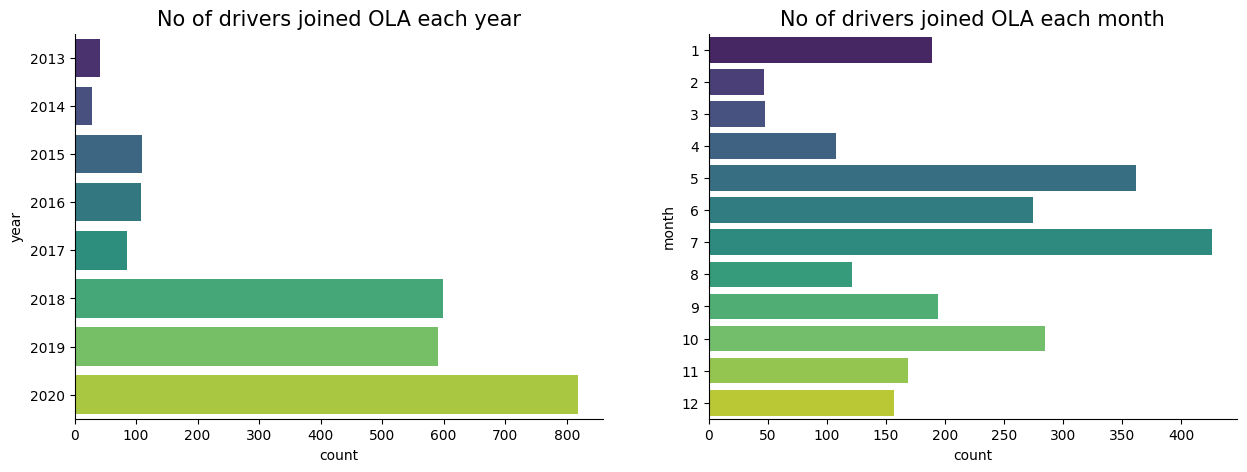

In [ ]:
# figure1

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
sns.countplot(y=df_ola_grouped.year,palette='viridis')
plt.title('No of drivers joined OLA each year',fontname='Franklin Gothic Medium', fontsize=15)


ax = fig.add_subplot(1,2,2)
sns.countplot(y=df_ola_grouped.month,palette='viridis')
plt.title('No of drivers joined OLA each month',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()


**Insights:**

- Joining of Drivers receives a boost of about 500% after 2017.
- July received the maximum number of drivers in 8 years.
- February and March receives the least number of Drivers joining OLA.


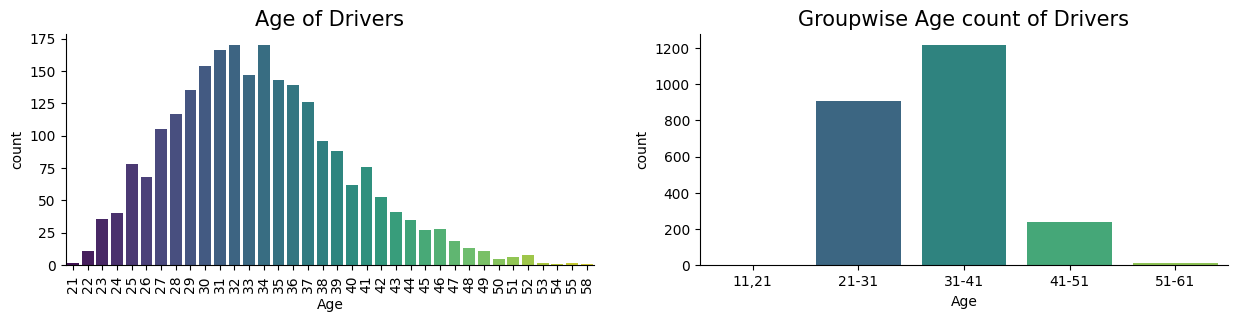

In [ ]:
# figure2
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(121)
sns.countplot(x=df_ola_grouped.Age,palette='viridis',width=0.8)
plt.title('Age of Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.xticks(rotation=90)

ax = fig.add_subplot(122)
a = pd.cut(df_ola_grouped.Age,bins=[11,21,31,41,51,61],labels=['11,21','21-31','31-41','41-51','51-61'])
sns.countplot(x=a,palette='viridis')
plt.title('Groupwise Age count of Drivers',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

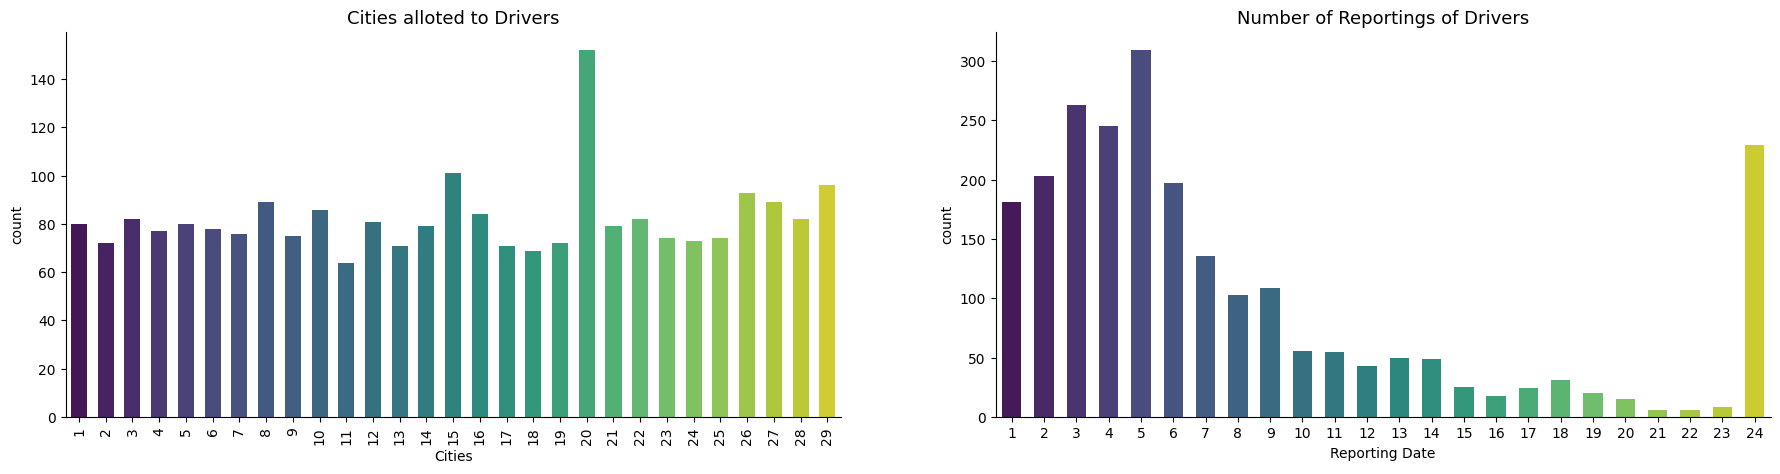

In [ ]:
# figure3
fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(121)
sns.countplot(x=df_ola_grouped.Cities,palette='viridis',width=0.6)
plt.title('Cities alloted to Drivers',fontname='Franklin Gothic Medium', fontsize=13)
plt.xticks(rotation=90)

ax = fig.add_subplot(122)
sns.countplot(x=df_ola_grouped['Reporting Date'],palette='viridis',width=0.6)
plt.title('Number of Reportings of Drivers',fontname='Franklin Gothic Medium', fontsize=13)

# ax = fig.add_subplot(133)
# sns.countplot(x=df_ola_grouped.Education_Level,palette='viridis')
# plt.title('Educational Level of Drivers',fontname='Franklin Gothic Medium', fontsize=13)
sns.despine()
plt.show()

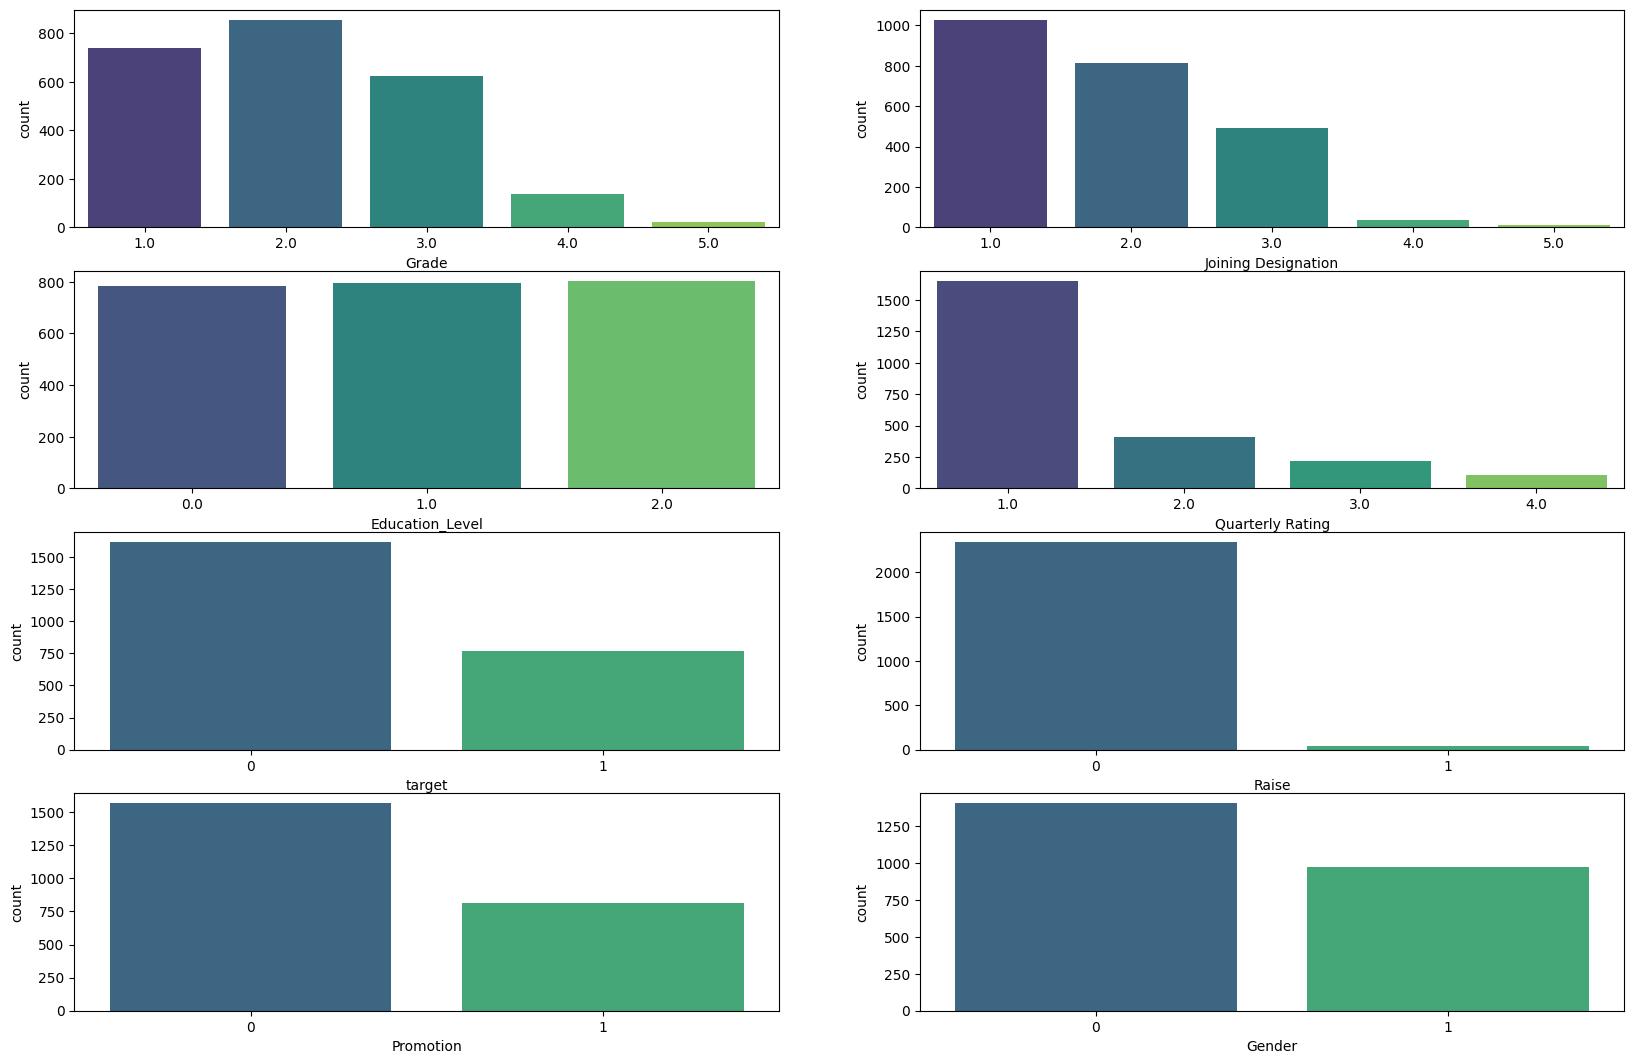

In [ ]:
# figure4
plt.figure(figsize=(20,13))
plt.subplot(4,2,1)
sns.countplot(x=df_ola_grouped.Grade,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,2)
sns.countplot(x=df_ola_grouped['Joining Designation'],palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,3)
sns.countplot(x=df_ola_grouped.Education_Level,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,4)
sns.countplot(x=df_ola_grouped['Quarterly Rating'],palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,5)
sns.countplot(x=df_ola_grouped.target,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,6)
sns.countplot(x=df_ola_grouped.Raise,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,7)
sns.countplot(x=df_ola_grouped.Promotion,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,8)
sns.countplot(x=df_ola_grouped.Gender,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.show()

**Insights:**

- Between 21 years(min age) to 58(max age) years of age, maximum number of drivers are 32 years o
meanwhile the age group between 31-41 years of age receives the maximum number of drivers.
- 58.9% of the Drivers are male.
- City C20 has been used by the most of the drivers.
- There are 3 Education levels and all of them alomst have the equal distribution of Drivers.
- Grade 2 has been received by most of the Drivers and then the count of grade keeps on falling.

<ipython-input-58-01ebd315aa7c>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_ola_grouped[i],color='teal')


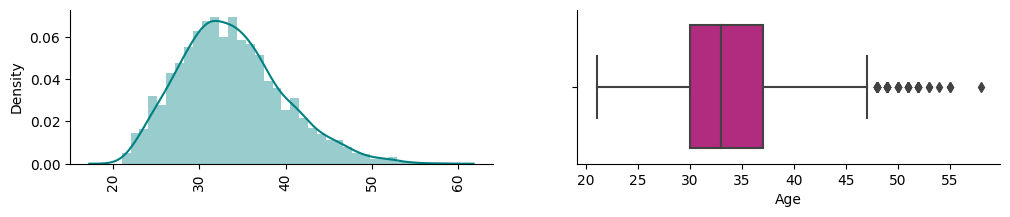

<ipython-input-58-01ebd315aa7c>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_ola_grouped[i],color='teal')


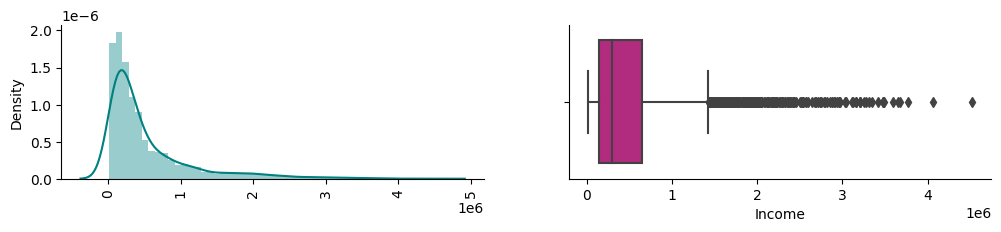

<ipython-input-58-01ebd315aa7c>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_ola_grouped[i],color='teal')


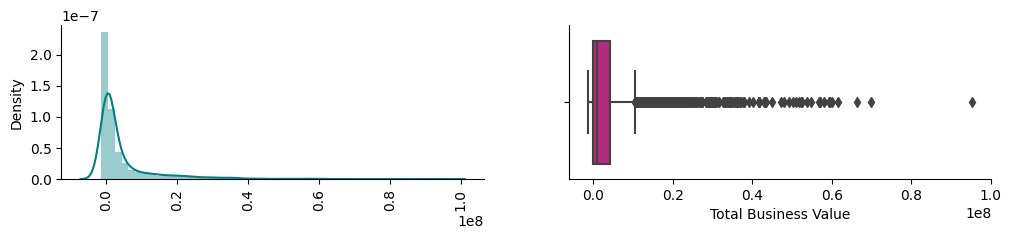

In [ ]:
a =df_ola_grouped[['Age','Income','Total Business Value']]
for i in a:
    plt.figure(figsize=(12,2))
    plt.subplot(121)
    sns.distplot(x=df_ola_grouped[i],color='teal')
    plt.title('')
    plt.xticks(rotation=90)

    plt.subplot(122)
    sns.boxplot(x=df_ola_grouped[i],color='mediumvioletred')
    plt.title('')
    sns.despine()
    plt.show()

# **Bivariate and multivariate Analysis**


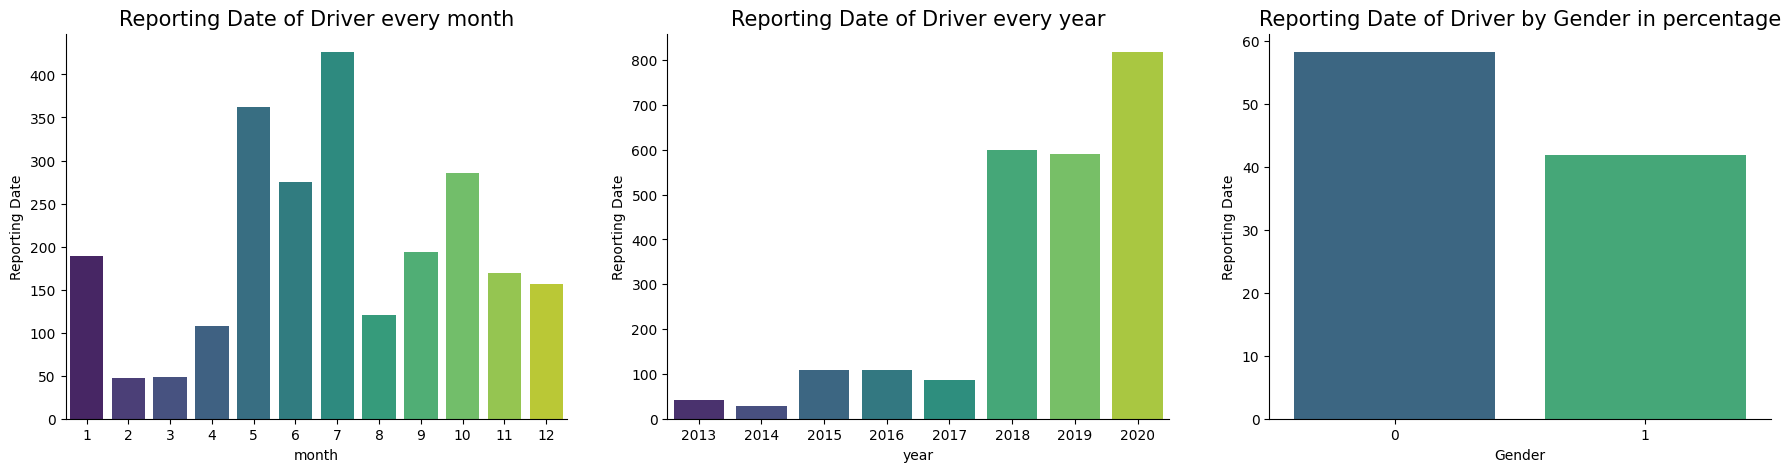

In [ ]:
fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(1,3,1)
grouped_months = df_ola_grouped.groupby(['month'])['Reporting Date'].count().reset_index()
sns.barplot(data=grouped_months,x='month',y='Reporting Date',palette='viridis')
plt.title('Reporting Date of Driver every month',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,3,2)
grouped_years = df_ola_grouped.groupby(['year'])['Reporting Date'].count().reset_index()
sns.barplot(x='year', y='Reporting Date', data=grouped_years,palette='viridis')
plt.title('Reporting Date of Driver every year',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,3,3)
grouped_gender = df_ola_grouped.groupby('Gender')['Reporting Date'].sum().reset_index()
grouped_gender['Reporting Date'] =(grouped_gender['Reporting Date']/sum(df_ola_grouped['Reporting Date'])*100).round(2)
sns.barplot(x=grouped_gender['Gender'],y= grouped_gender['Reporting Date'],palette='viridis')
plt.title('Reporting Date of Driver by Gender in percentage',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
sns.despine()
plt.show()

In [ ]:
grouped_gender

,Gender,Reporting Date
0,0,58.19
1,1,41.81


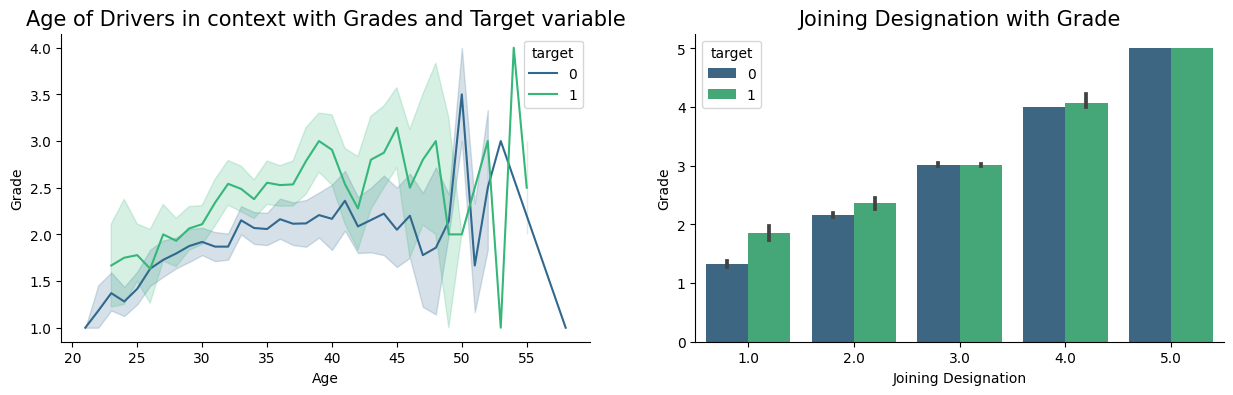

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
sns.lineplot(x=df_ola_grouped.Age,y=df_ola_grouped.Grade,hue=df_ola_grouped.target,palette='viridis')
plt.title('Age of Drivers in context with Grades and Target variable',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,2,2)
sns.barplot(data=df_ola_grouped, x="Joining Designation", y="Grade",palette='viridis',hue='target')
plt.title('Joining Designation with Grade',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

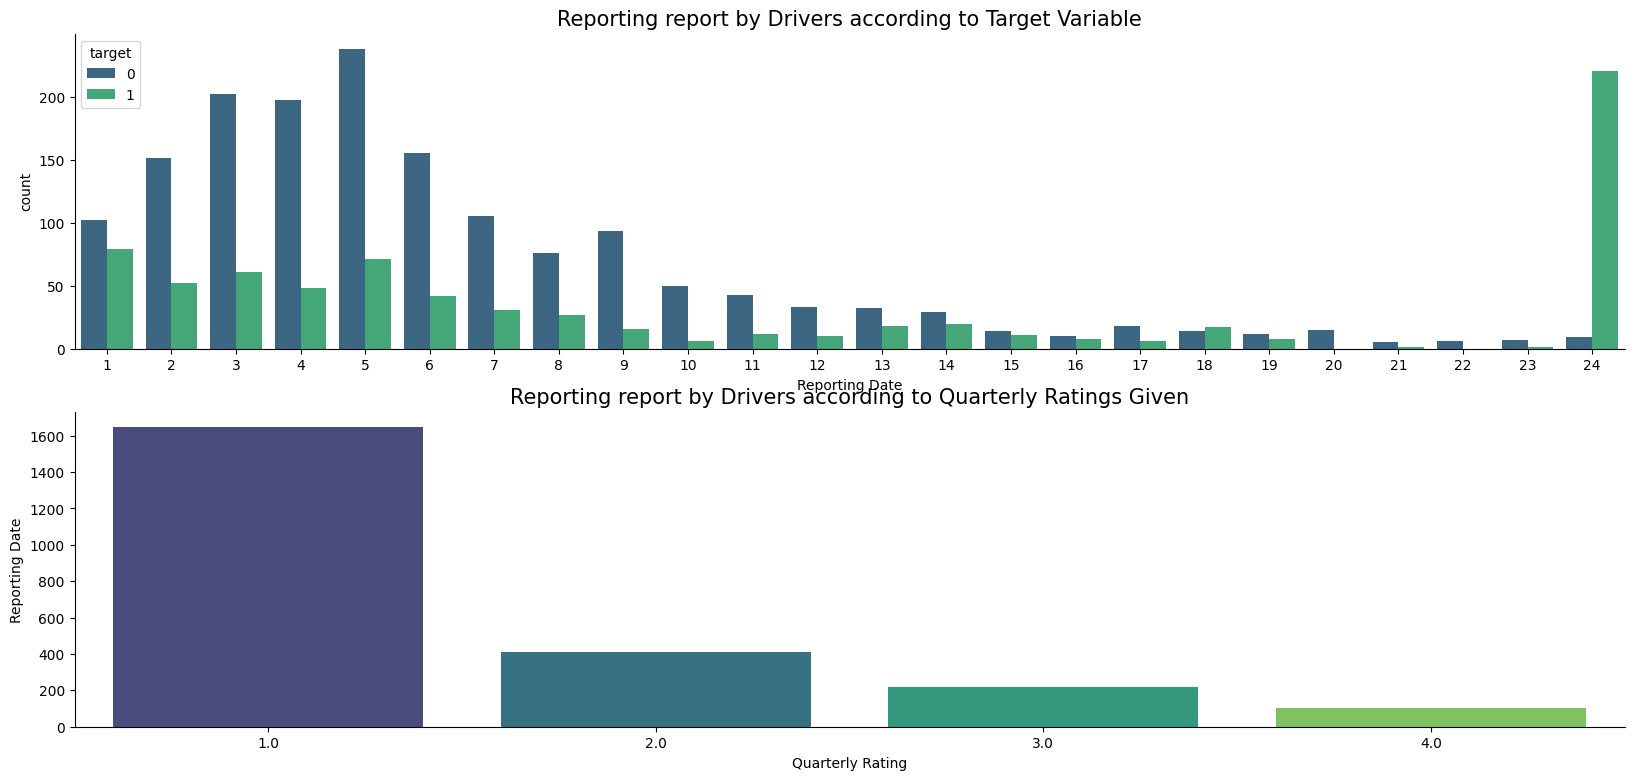

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,1,1)
sns.countplot(x=df_ola_grouped['Reporting Date'],hue=df_ola_grouped.target,palette='viridis')
plt.title('Reporting report by Drivers according to Target Variable',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(2,1,2)
grouped_rating = df_ola_grouped.groupby('Quarterly Rating')['Reporting Date'].count().reset_index()
sns.barplot(data = grouped_rating,y='Reporting Date',x='Quarterly Rating',palette='viridis')
plt.title('Reporting report by Drivers according to Quarterly Ratings Given',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

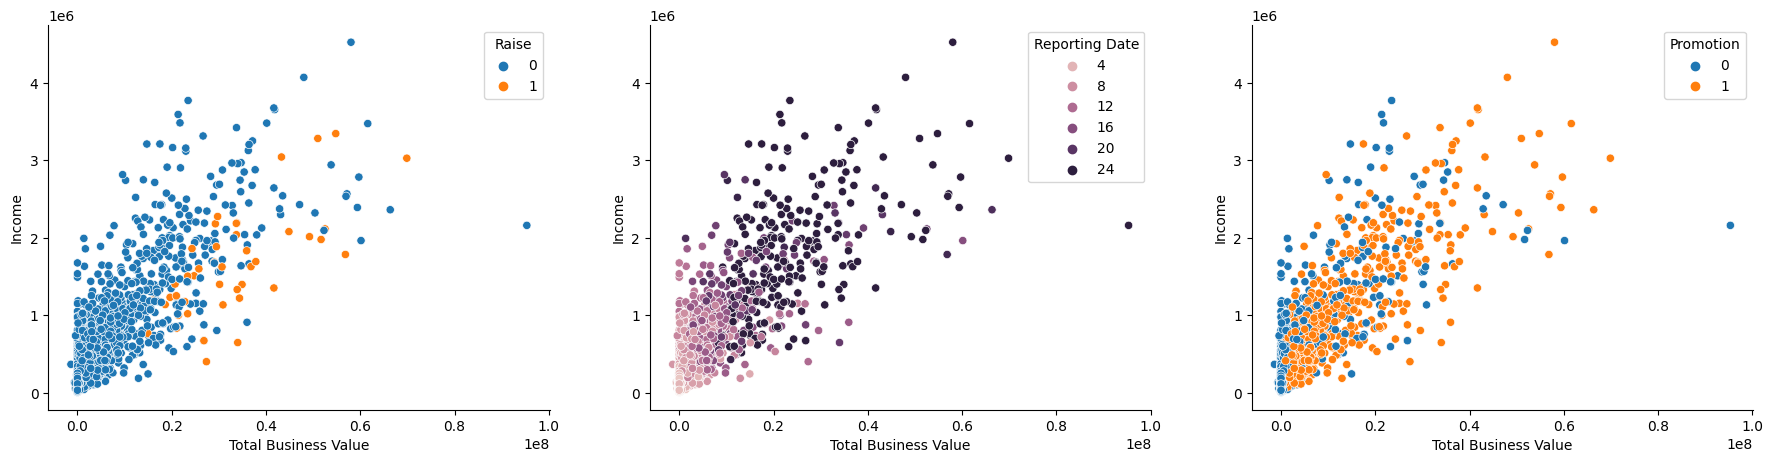

In [ ]:
plt.figure(figsize=(22,5))
plt.subplot(1,3,1)
sns.scatterplot(x=df_ola_grouped['Total Business Value'],y=df_ola_grouped.Income,hue=df_ola_grouped.Raise)
plt.subplot(1,3,2)
sns.scatterplot(x=df_ola_grouped['Total Business Value'],y=df_ola_grouped.Income,hue=df_ola_grouped['Reporting Date'])
plt.subplot(1,3,3)
sns.scatterplot(x=df_ola_grouped['Total Business Value'],y=df_ola_grouped.Income,hue=df_ola_grouped.Promotion)
sns.despine()
plt.show()

**Insights:-**

1.	Here we can see that there are 57% male employees and 43% female employees.

2.	Only 54.6% of the employees received a promotion, while 45.4% did not. However, only 2.6% received a raise in income.

3.	Number of employees has been increase with increase in year as well as number of reportings.

4.	The percentages of employees with different education levels are almost same for level 1 & 2.

5.	97.3% of the employees who did not get a raise.

6.	Scatter plot of Total Business Value shows an increase with increase in Age yet we notice a decline after 45.

7.	Income decreses with increase in Destination as about 4% of the employees hold higher designations.

8.	Almost 43% of the employees joined at lowest designation (1). 34% joined at level 2, 20% at level 3 and below 2% joined at higher levels.

9.	Majority (35%) of the employees currently are at designation level 2, followed by designation level 1 (31%) and 3 (26%). Less than 5% of the employees are currently in higher designations.

10.	The majority of the employees seem to be associated with city C20.

11.	Scatter plot of Income shows that Income increases with increase in age but after 45-50, we see a subtle decline.

12.	Max reporting days is 24 days.

13.	About 55% of the reportings of the employees has got Quarlerly Rating 1.

14.	The median of the Income for employees having higher Grades is greater.

15.	Distribution of Income for enployes at different Education level is about a change of 3-5% with level 0.

16.	Joining Designation Increases with increase in Grade.


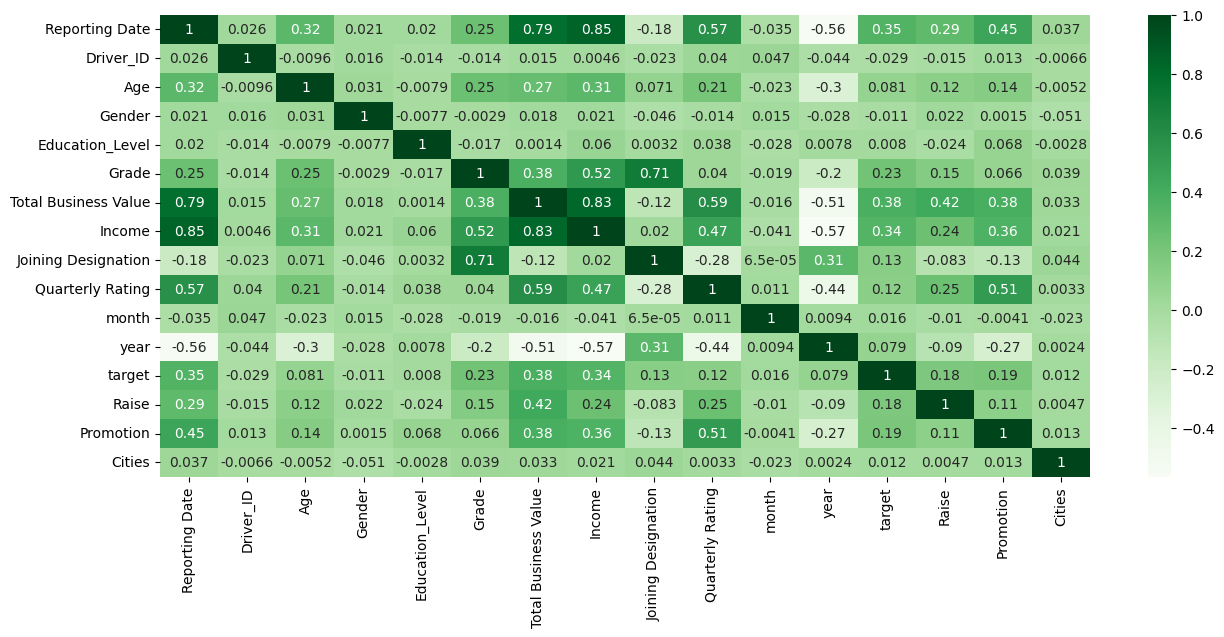

In [ ]:
corr = df_ola_grouped.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr,annot=True,cmap='Greens')
plt.show()

**Insights**

- Income and Grade is highly correlated

-  Joining Designation and Grade is highly correlated

- Total Business value and salary increament is correlated

# **Data Preprocessing**

# **One-Hot Encoding**

Since there is only one categorical values in our dataset. We will opt one hot encoder to convert it to numerical.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the data.
df_city = df_ola_grouped['Cities'].reset_index()
print(df_city)
encoder.fit(df_city)

# Encode the data.
encoded_data = encoder.transform(df_city)

# Print the encoded data.
print(encoded_data)

      index  Cities
0         0      23
1         1       7
2         2      13
3         3       9
4         4      11
...     ...     ...
2376   2376      24
2377   2377       9
2378   2378      19
2379   2379      20
2380   2380      27

[2381 rows x 2 columns]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# **Standardization (for training data)**

In [ ]:
X = df_ola_grouped.drop(["Driver_ID", "target", "Cities"], axis = 1)
X_cols = X.columns
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

In [ ]:
X = pd.DataFrame(X)

X.columns = X_cols

X.head()

,Reporting Date,Age,Gender,Education_Level,Grade,Total Business Value,Income,Joining Designation,Quarterly Rating,month,year,Raise,Promotion
0,0.086957,0.189189,0.0,1.0,0.00,0.032064,0.035751,0.00,0.333333,1.000000,0.714286,0.0,0.0
1,0.043478,0.270270,0.0,1.0,0.25,0.014326,0.027299,0.25,0.000000,1.000000,1.000000,0.0,0.0
2,0.173913,0.594595,0.0,1.0,0.25,0.017944,0.070300,0.25,0.000000,0.909091,0.857143,0.0,0.0
3,0.086957,0.216216,0.0,0.0,0.00,0.015570,0.028423,0.00,0.000000,1.000000,0.857143,0.0,0.0
4,0.173913,0.270270,1.0,0.5,0.50,0.027405,0.084847,0.50,0.000000,1.000000,1.000000,0.0,1.0


# **Train & Test Split**

In [ ]:
y = df_ola_grouped["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=True)

In [ ]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (1904, 13)
X_test Shape:  (477, 13)
y_train Shape:  (1904,)
y_test Shape:  (477,)


In [ ]:
import time

**Random Forest with balanced class weights**

Random forest is an ensemble learning algorithm that combines the predictions of multiple decision trees to make a final prediction. It works by training a large number of decision trees on different subsets of the data. Each decision tree makes a prediction, and the final prediction is the average of the predictions from the individual trees.

Random forest is a powerful algorithm that can be used for both classification and regression tasks. It is particularly well-suited for tasks with imbalanced classes, as it can help to reduce bias.

To use random forest with balanced class weights, you can specify the class_weight parameter when training the model. The class_weight parameter takes a dictionary that maps each class to its weight. The higher the weight, the more important that class is in the training process.

In [ ]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 50}
Best Score:  0.7789377023373922

Elapsed Time:  11.3800687789917


The best score we found was 0.783, which is quie low hence we can try different combinations to find a better score.

Also, we need to assume/try new paramters to find higher score.

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       329
           1       0.72      0.87      0.79       148

    accuracy                           0.86       477
   macro avg       0.83      0.86      0.84       477
weighted avg       0.87      0.86      0.86       477



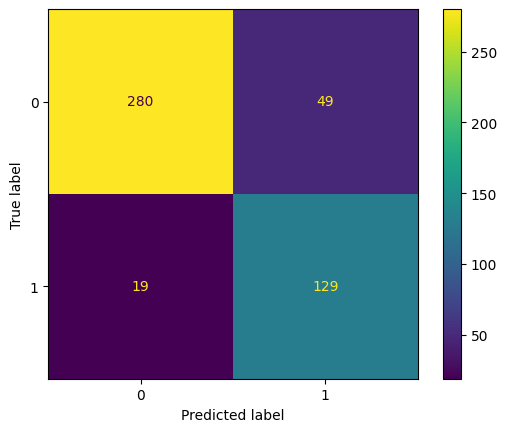

In [ ]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

Insight:

Out of all prediction, the measure for correctly predicted 0 is 94% and for 1 is 73% (Precision)

Out of all actual 0, the measure for correctly predicted is 85% and for 1 is 89% (Recall)
As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 89%

F1 Score of 1 is 80%

**Random Forest Classifier with balanced subsample**

We can also try out, bootstrapped random forest using subsample

In [ ]:
y = df_ola_grouped["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=True)

In [ ]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 200}
Best Score:  0.7847728847728849

Elapsed Time:  12.45423698425293


              precision    recall  f1-score   support

           0       0.95      0.77      0.85       329
           1       0.64      0.91      0.75       148

    accuracy                           0.81       477
   macro avg       0.80      0.84      0.80       477
weighted avg       0.85      0.81      0.82       477



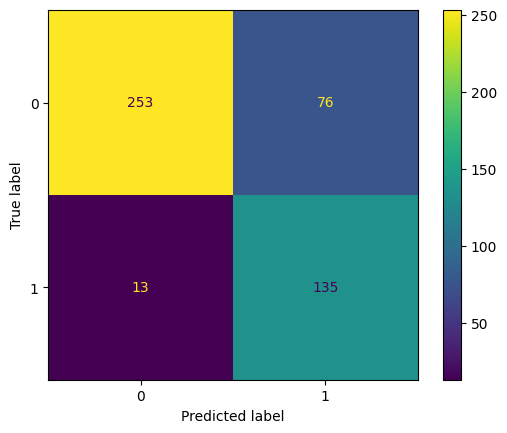

In [ ]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

**Insight:**

Out of all prediction, the measure for correctly predicted 0 is 94% and for 1 is 66% (Precision)

Out of all actual 0, the measure for correctly predicted is 79% and for 1 is 89% (Recall)

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 86%

F1 Score of 1 is 76%

**There is not much significant difference in the best scores observed for bootstrapped Random Forest and Weighted Random Forest**

We will not try balancing

# **Balancing Dataset using SMOTE**

As the target variable is imbalanced towards 1. We will use SMOTE to balance the dataset

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 617
Before OverSampling, counts of label '0': 1287 



In [ ]:
sm = SMOTE(random_state = 7)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

After OverSampling, the shape of train_X: (2574, 13)
After OverSampling, the shape of train_y: (2574,) 

After OverSampling, counts of label '1': 1287
After OverSampling, counts of label '0': 1287


# **Ensemble Learning: Bagging (with Hyperparamter tuning)**

Bagging (short for bootstrap aggregating) is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting.

Bagging works by training multiple models on different subsets of the training data. The predictions from these models are then combined to make a final prediction. This can be done by averaging the predictions from the individual models, or by voting in the case of classification problems.

The key idea behind bagging is that by training multiple models on different subsets of the data, we can reduce the variance of the final prediction. This is because the different models will be less likely to all make the same mistake.

We would be doing **Hyper parameter tuning** using Grid Search and Radom Forest Classifier

In [ ]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced_subsample'),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1', verbose=True)

In [ ]:
print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

y_pred = c.predict(X_test)

Best Params:  {'max_depth': 4, 'n_estimators': 100}
Best Score:  0.8671368779272769

Elapsed Time:  13.165948867797852


Here, we can see that the Best score has improved a lot from 0.81 to 0.86 for Balanced data set

We are again going to tune the parameters near the paramters found in the last iteration and then check for the best score.

In [ ]:
params = {
    "max_depth": [3, 4, 5, 6],
    "n_estimators": [100, 150, 200, 250],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params:  {'max_depth': 6, 'n_estimators': 250}
Best Score:  0.8867438645714122

Elapsed Time:  26.57045865058899


The Best score has increased againt to  0.884769676950666 for 'max_depth': 6, 'n_estimators': 150.

We will further check with higher max_depth

In [ ]:
params = {
    "max_depth": [5, 6, 7, 8],
    "n_estimators": [100, 150, 200, 250],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params:  {'max_depth': 8, 'n_estimators': 200}
Best Score:  0.8951375827548483

Elapsed Time:  26.08556628227234


The Best score has increased againt to  0.8926186054802372 for 'max_depth': 8, 'n_estimators': 250.

We will further check with higher max_depth and n_estimators

In [ ]:
params = {
    "max_depth": [7, 8, 9],
    "n_estimators": [150, 200, 250, 300],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 9, 'n_estimators': 250}
Best Score:  0.8988228446235121

Elapsed Time:  27.130854606628418


In [ ]:
params = {
    "max_depth": [8, 9, 10, 11],
    "n_estimators": [200, 250, 300],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 10, 'n_estimators': 300}
Best Score:  0.9011333979742476

Elapsed Time:  34.53837752342224


Since we want to avoid overfitting we willl settle for current set of parameters and run the same on Random forest classifier to predict the value of Y

In [ ]:
from sklearn.model_selection import KFold, cross_validate

In [ ]:
clf2 = RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini',
                              max_depth=11, n_estimators=300)

kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(clf2, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_acc_results['train_score'].mean()*100:.3f} \n Validation: {cv_acc_results['test_score'].mean()*100:.3f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_acc_results['train_score'].std()*100:.3f}, \n Validation: {cv_acc_results['test_score'].std()*100:.3f}")

K-Fold Accuracy Mean: 
 Train: 97.107 
 Validation: 87.989
K-Fold Accuracy Std: 
 Train: 0.251, 
 Validation: 2.073


In [ ]:
cv_acc_results

{'fit_time': array([1.59951091, 1.23206043, 1.0280416 , 1.02038765, 1.04056168,
        1.02606082, 1.03269339, 1.03806925, 1.02900577, 1.05784607]),
 'score_time': array([0.03865886, 0.03292656, 0.0343492 , 0.02856803, 0.03032899,
        0.02993941, 0.02853584, 0.02849269, 0.03068757, 0.05298543]),
 'test_score': array([0.86610879, 0.87815126, 0.87394958, 0.88655462, 0.91596639,
        0.83193277, 0.88655462, 0.88235294, 0.87815126, 0.89915966]),
 'train_score': array([0.96778711, 0.97153523, 0.97340177, 0.97153523, 0.96966869,
        0.96686888, 0.9710686 , 0.97433504, 0.97480168, 0.96966869])}

Since we are getting the best Training and validation accuracy for these values, we will find the predicted values of Y using this configuration.

In [ ]:
y_pred = c.predict(X_test)

**Confusion Matrix And Classification Report**

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       329
           1       0.71      0.84      0.77       148

    accuracy                           0.85       477
   macro avg       0.82      0.85      0.83       477
weighted avg       0.86      0.85      0.85       477



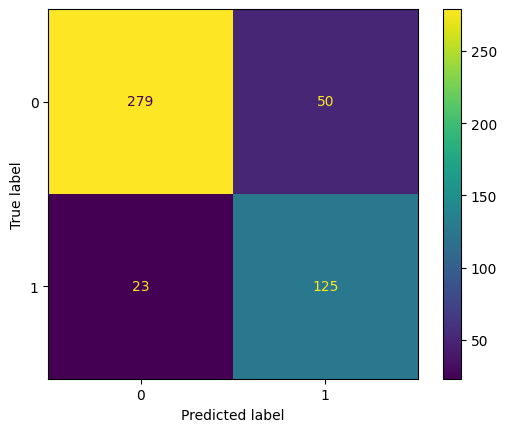

In [ ]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

Random Forest Classifier with balanced class weight

Out of all prediction, the measure for correctly predicted 0 is 93% and for 1 is 72% (Precision)

Out of all actual 0, the measure for correctly predicted is 85% and for 1 is 86% (Recall)

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 89%
F1 Score of 1 is 78%

**ROC-AUC Curve**

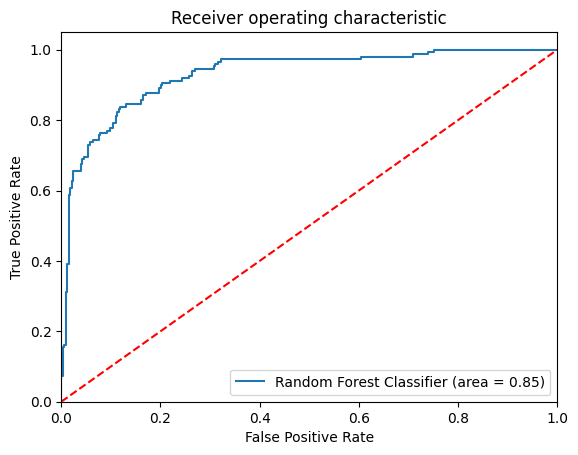

In [ ]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **Ensemble Learning: Boosting (with Hyperparamter tuning)**

Boosting is an ensemble meta-algorithm that combines weak learners to create a strong learner. It works by training a series of models, each of which is trained on a different subset of the data. The models are then combined to make a final prediction.

The key idea behind boosting is that each model is trained to focus on the instances that the previous models did not classify correctly. This helps to reduce the bias of the final prediction.

Boosting can be used with any type of machine learning algorithm, but it is most commonly used with decision trees. This is because decision trees are prone to overfitting, and boosting can help to reduce this problem.

In [ ]:
params = {
    "max_depth": [2, 3, 4],
    "loss": ["log_loss", "exponential"],
    "subsample": [0.1, 0.2, 0.5, 0.8, 1],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [50,100,150,200]
}

gbdt = GradientBoostingClassifier()
start_time = time.time()
c = GridSearchCV(estimator=gbdt, cv=3, n_jobs=-1, verbose=True, param_grid=params)

c.fit(X_train, y_train)
print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)

elapsed_time = time.time() - start_time
print("\n Elapsed Time: ", elapsed_time)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Params:  {'learning_rate': 0.3, 'loss': 'exponential', 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
Best Score:  0.8978243978243978

 Elapsed Time:  316.65255427360535


In [ ]:
params = {
    "max_depth": [3, 4, 5, 6],
    "loss": ["log_loss", "exponential"],
    "subsample": [0.1, 0.2, 0.5, 0.8, 1],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [100,150,200, 250]
}

gbdt = GradientBoostingClassifier()
start_time = time.time()
c = GridSearchCV(estimator=gbdt, cv=3, n_jobs=-1, verbose=True, param_grid=params)

c.fit(X_train, y_train)
print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)

elapsed_time = time.time() - start_time
print("\n Elapsed Time: ", elapsed_time)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Best Params:  {'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 250, 'subsample': 1}
Best Score:  0.8986013986013986

 Elapsed Time:  816.669150352478


Fixing few parameters like learning_rate, loss, subsample...we increase other values of max_depth and n_estimators

In [ ]:
params = {
    "max_depth": [5, 6, 7, 8],
    "loss": ["exponential"],
    "subsample": [0.8],
    "learning_rate": [0.3],
    "n_estimators": [200, 250, 300]
}

gbdt = GradientBoostingClassifier()
start_time = time.time()
c = GridSearchCV(estimator=gbdt, cv=3, n_jobs=-1, verbose=True, param_grid=params)

c.fit(X_train, y_train)
print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)

elapsed_time = time.time() - start_time
print("\n Elapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'learning_rate': 0.3, 'loss': 'exponential', 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}
Best Score:  0.8958818958818959

 Elapsed Time:  58.03224968910217


Since the Best is decreasing now we will fix the paramters from the last run as the final parameters which is 'learning_rate': 0.3, 'loss': 'exponential', 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.8

In [ ]:
clf3 = GradientBoostingClassifier(random_state=7, learning_rate = 0.3, loss= 'exponential', max_depth = 6, n_estimators= 250, subsample = 0.8)

kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(clf3, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_acc_results['train_score'].mean()*100:.3f} \n Validation: {cv_acc_results['test_score'].mean()*100:.3f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_acc_results['train_score'].std()*100:.3f}, \n Validation: {cv_acc_results['test_score'].std()*100:.3f}")

K-Fold Accuracy Mean: 
 Train: 100.000 
 Validation: 88.072
K-Fold Accuracy Std: 
 Train: 0.000, 
 Validation: 1.234


In [100]:
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       329
           1       0.72      0.82      0.77       148

    accuracy                           0.85       477
   macro avg       0.82      0.84      0.83       477
weighted avg       0.85      0.85      0.85       477



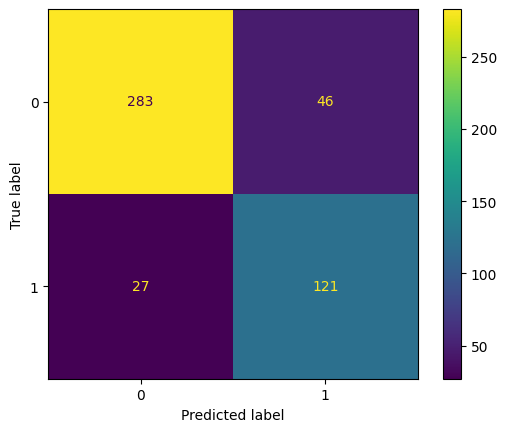

In [101]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

**Gradient Boosting Classifier Metrics**

Out of all prediction, the measure for correctly predicted 0 is 91% and for 1 is 72% (Precision)

Out of all actual 0, the measure for correctly predicted is 86% and for 1 is 82% (Recall)

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 89%
F1 Score of 1 is 77%

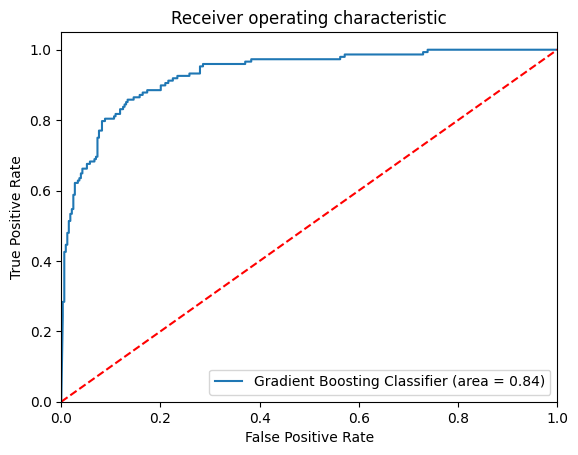

In [102]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Gradient Boosting Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **XGBoost Classifier**

The XGBoost classifier is a boosting ensemble meta-algorithm that combines weak learners to create a strong learner. It works by training a series of models, each of which is trained on a different subset of the data. The models are then combined to make a final prediction.

The key idea behind XGBoost is that each model is trained to focus on the instances that the previous models did not classify correctly. This helps to reduce the bias of the final prediction.

XGBoost can be used with any type of machine learning algorithm, but it is most commonly used with decision trees. This is because decision trees are prone to overfitting, and XGBoost can help to reduce this problem.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:29:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Score:  0.8385744234800838

               precision    recall  f1-score   support

           0       0.91      0.84      0.88       329
           1       0.71      0.82      0.76       148

    accuracy                           0.84       477
   macro avg       0.81      0.83      0.82       477
weighted avg       0.85      0.84      0.84       477



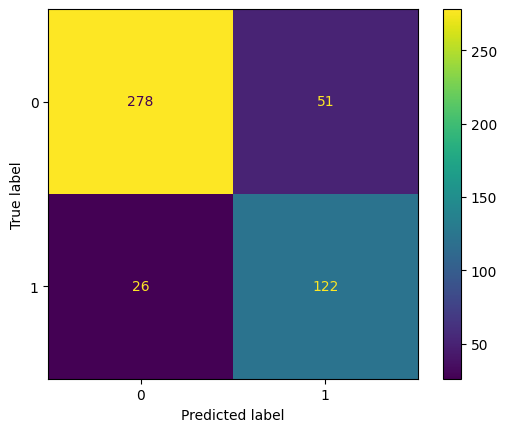

In [103]:
model = xgb.XGBClassifier(class_weight = "balanced")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("XGBoost Classifier Score: ", model.score(X_test, y_test))
print("\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

**XGBoost Classifier with balanced class weight**

Out of all prediction, the measure for correctly predicted 0 is 91% and for 1 is 71% (Precision)

Out of all actual 0, the measure for correctly predicted is 84% and for 1 is 82% (Recall)

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 88%

F1 Score of 1 is 76%

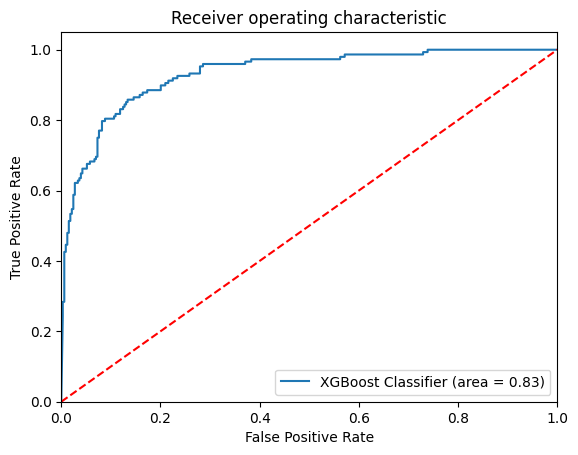

In [104]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [105]:
clf2 = RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini',
                              max_depth=11, n_estimators=300)
clf2.fit(X_train, y_train)
print("Score of RandomForestClassifier: ", clf2.score(X_test, y_test))

Score of RandomForestClassifier:  0.8574423480083857


In [107]:
importances = clf2.feature_importances_
importances

array([0.205039  , 0.03926522, 0.00689382, 0.01393705, 0.03996472,
       0.15864167, 0.09616239, 0.04249809, 0.04318444, 0.02951992,
       0.28903264, 0.00326084, 0.03260021])

In [109]:
std = np.std([tree.feature_importances_ for tree in clf2.estimators_], axis=0)

<Figure size 1500x700 with 0 Axes>

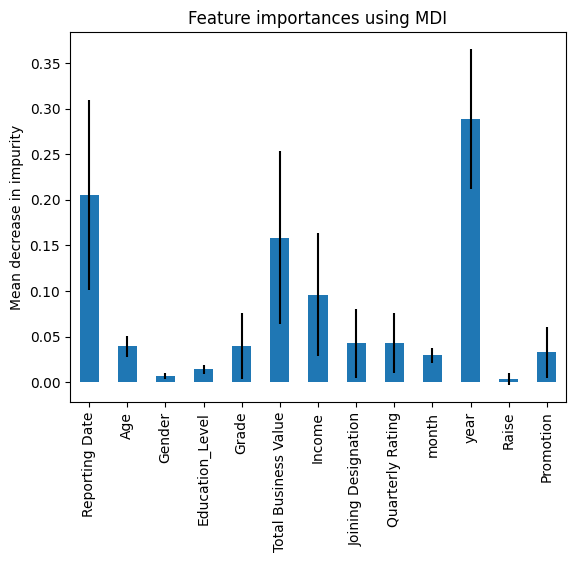

In [110]:
feature_importances = pd.Series(importances, X_train.columns)

plt.figure(figsize=(15,7))
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

plt.show()

**Insights**

Year, Total_Business_Value & Reporting Date are the most important features

# **Actionable Insights and Recommendation**

1.	Out of 2381 drivers 1616 have left the company.

2.	Out of 2381 employees, 1744 employees had their last quarterly rating as 1.

3.	Out of 2381 employees, the quarterly rating has not increased for 2076 employees. This is red flag for the company which needs to regulate.

4.	The employees whose monthly salary has not increased are more likely to leave the organization.

5.	We need to incentivize the drivers overtime or other perks to overcome churning.

6.	The employees whose quarterly rating has increased are less likely to leave the organization.

7.	Company needs to get in touch with those drivers whose monthly salary has not increased and help them out to earn more by provider bonus and perks.

8.	Company needs to look why customers are not rating drivers.

9.	Company needs to implement the reward system for the customer who provide the feedback and rate drivers.

10.	Last_Quarterly_Rating, Total_Business_Value & Quarterly_Rating_Increased are the most important features. Company needs to tracks these features as predicators

11.	We observe that we are not getting very high recall on target 0 which may be due to small unbalanced dataset. More data will overcome this issue.

12.	The Random Forest Classifier attains the Recall score of 91% for the driver who left the company. Which indicates that model is performing the decent job.
